In [1]:
import lib
from lib import get_img_files
import os
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

# Введение
Основным материалом является документ. Этот документ атомарно состоит из строк. 
Первым делом необходимо выделить из изоброжения картинки строк, чтоб потом можно было с ними что-то делать. 
Предполагается, что программа в которой будет проводится классификация может давать строки.
В случае этого проекта эту роль имитирует функция get_row_image(path_img)


Доступные файлы для работы, это файлы к которым есть .npy файл, так как программа опирается на него


In [2]:


files = get_img_files()

0: border.png
1: border2.png
2: img_10.jpeg
3: text_1.png
4: text_11.png
5: text_12.jpeg
6: text_13.png
7: text_17.png
8: text_19.png
9: text_2.png
10: text_20.png
11: text_21.png
12: text_4.png
13: text_5.png
14: text_6.png
15: text_7.png
16: text_8.png
17: text_9.png


In [3]:
path_img = os.path.join(lib.PATH_IMG,files[10])
data = lib.get_row_image(path_img)


img_doc = data["img"]
npy_mtrx_doc = data["npy"]
rows = data["image_rows"]
# Показать!
# lib.draw_img(img_doc, [], []) 

В результате имеем само изображение, матрицу ручной разметки и собственно список строк документа
с которомы дальше нужно работать

# Идеи
Далее будут представленны методы и идеи как работать со строками. Вся работа будет вестись со списком rows

### Поиск уникальной строки
Строки могут быть трех видов:
1. Обычный текст
2. Жирный текст
3. Смешенный текст

При этом эти две категории можно поделить на две:
1. Однородный текст
2. Неоднородный текст

Предполагается, что задача классификации на две категории куда проще, чем на 3

In [4]:
def delta_coef(rows):
    info_row = []
    type_row = []

    for j in range(len(rows)):
        row_gray = cv2.cvtColor(rows[j], cv2.COLOR_BGR2GRAY)
        words_row = pytesseract.image_to_data(row_gray, config="-l rus+eng --psm 7", output_type=pytesseract.Output.DICT)
        array_coef = []
        N = len(words_row["word_num"])
        for i in range(N):
            if words_row["level"][i] == 5:
                x0, y0, w0, h0 = words_row["left"][i], words_row["top"][i], words_row["width"][i], words_row["height"][i]
                word_img = row_gray[y0:y0+h0, x0:x0+w0]
                word_img = (255-word_img)/255
                coef = word_img.mean()

                if w0 > h0*3: # Слова из 1-3 символов являются проблемой
                    array_coef.append(coef)

        if len(array_coef) == 0:
            k = 0
        else:
            min_word = np.min(array_coef)
            max_word = np.max(array_coef)
            k = max_word-min_word
        print("\r"+f"{j/len(rows):2.2f} % ", end="")

        info_row.append(k)
        type_row.append(2 if k > 40 else 0)
    print("\r 100.00 %")
    return info_row, type_row


In [5]:
# ВЫВОД
# info_row, type_row = delta_coef(rows)
# lib.draw_img(img_doc, npy_mtrx_doc, type_row, info_row)

### Корреляция
Ключевыми значениями для слов являются:
- среднее значения интенсивности
- пороговое кол-во символов (например 0-10, 10-20, 20-30, ...)
- минимальное и максимальное значения

попробуем построить графические зависимости с целью выявить закономерность

In [6]:
def mean_row(row):
    h, w, _ = row.shape
    return row.mean()

def std_row(row):
    return row.std()

def row_level_0_10(row):
    h, w, _ = row.shape
    row = row[row < 10]
    return len(row)/(h*w)

def row_level_10_20(row):
    h, w, _ = row.shape
    row = row[row < 20]
    row = row[row > 10]
    return len(row)/(h*w)

def row_level_20_30(row):
    h, w, _ = row.shape
    row = row[row < 30]
    row = row[row > 20]
    return len(row)/(h*w)

def get_coef_fun(rows, fun):
    array_coef = []
    for row in rows:
        coef = fun(row)
        array_coef.append(coef)
    array_coef = np.array(array_coef)
    if array_coef.max() == 0:
        return array_coef
    else:
        return array_coef/array_coef.max()

def std_word_level_0_10(row):
    gray_row = cv2.cvtColor(row, cv2.COLOR_BGR2GRAY)
    words_row = pytesseract.image_to_boxes(gray_row, config="-l rus+eng --psm 7", output_type=pytesseract.Output.DICT)
    array_coef = []
    N = len(words_row["char"])
    for i in range(N):
        
        x0, y0, x1, y1 = words_row["left"][i], words_row["top"][i], words_row["right"][i], words_row["bottom"][i]
        word_img = gray_row[y1:y0, x0:x1]
        word_img = word_img[word_img < 30]
        array_coef.append(len(word_img))
    array_coef = np.array(array_coef)
    return array_coef.mean()
            

def std_mean_row(row):
    return abs(row.mean()-row.std())

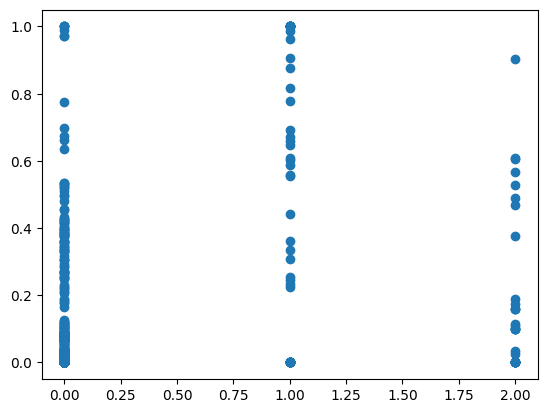

In [41]:
x_all = []
y_all = []
for i in range(len(files)):
    path_img = os.path.join(lib.PATH_IMG,files[i])
    data = lib.get_row_image(path_img)

    
    img_doc = data["img"]
    npy_mtrx_doc = data["npy"]
    rows = data["image_rows"]
    
    x = npy_mtrx_doc[:, 0]
#     y = get_coef_fun(rows, mean_row)
#     y = get_coef_fun(rows, std_row)
    y = get_coef_fun(rows, row_level_0_10)
#     y = get_coef_fun(rows, row_level_10_20)
#     y = get_coef_fun(rows, row_level_20_30)
#     y = get_coef_fun(rows, std_mean_row)
    
#     y1 = get_coef_fun(rows, row_level_10_20)
#     y2 = get_coef_fun(rows, row_level_20_30)
#     y3 = get_coef_fun(rows, std_mean_row)
#     y = np.zeros_like(y1)
#     for i in range(len(y1)):
#         y[i] = min(y1[i], y2[i], y3[i])

    mean_row
    x_all.extend(x)
    y_all.extend(y)

plt.plot(x_all, y_all, "o")    


### Проведем анализ смешенной строки

In [42]:
N_file = 5
N_row = 1

path_img = os.path.join(lib.PATH_IMG,files[N_file])
data = lib.get_row_image(path_img)


img_doc = data["img"]
npy_mtrx_doc = data["npy"]
rows = data["image_rows"]
img = (255-cv2.cvtColor(rows[N_row], cv2.COLOR_BGR2GRAY))

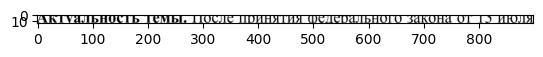

In [44]:
plt.imshow(rows[N_row][6:21,:])

In [10]:
y0 = img.sum(1)
y1 = img.sum(0)

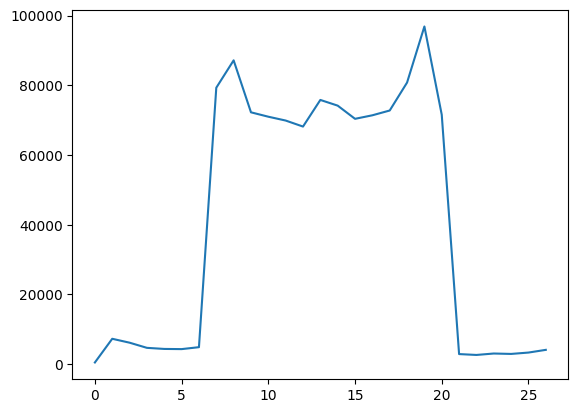

In [11]:
plt.plot(y0)  

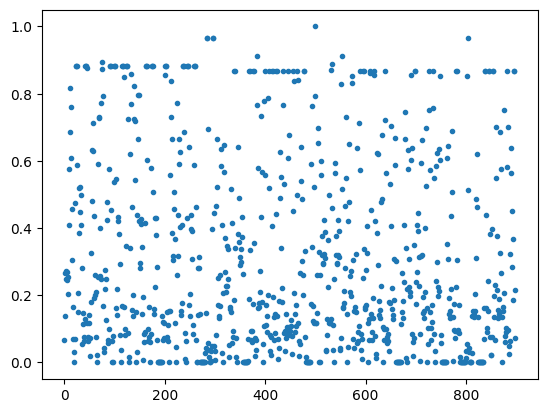

In [12]:
y0 = img[6:21,:].sum(1)
y1 = img[6:21,:].sum(0)
y1 = y1/(len(y0)*255)
plt.plot(y1, ".") 

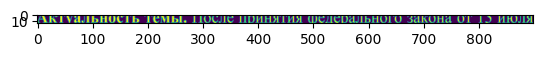

In [13]:
plt.imshow(img[6:21,:])

In [14]:
def char_sum(y):
    rez = [0]
    k = 0
    d = 1
    run = True
    for i in range(len(y)):
        if y[i] > 0.05:
            rez[k] += y[i]
            d += 1
            run = True
        else:
            if run:
                rez[k] = rez[k]/d
                d = 1
                k += 1
                rez.append(0)
                run = False
    return rez
        

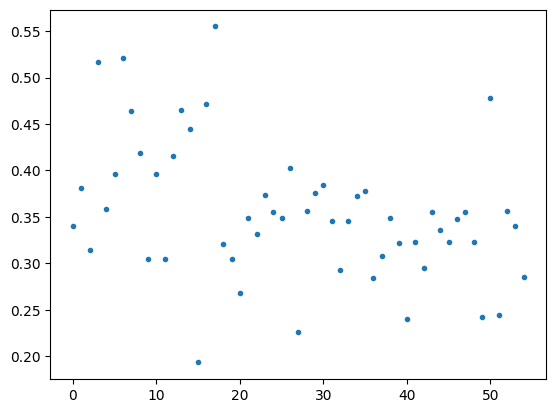

In [15]:
y0 = img[6:21,:].sum(1)
y1 = img[6:21,:].sum(0)
y1 = y1/(len(y0)*255)
y2 = np.array(char_sum(y1))
plt.plot(y2[:-1], ".") 

In [16]:
y2.mean(), y2.std()

(0.4357374491855042, 0.6058490458519946)

По результатам можно сделать следующую функцию, которая будет находить эти величины

In [17]:
def char_sum(y):
    rez = [0]
    k = 0
    d = 1
    run = True
    for i in range(len(y)):
        if y[i] > 0.05:
            rez[k] += y[i]
            d += 1
            run = True
        else:
            if run:
                rez[k] = rez[k]/d
                d = 1
                k += 1
                rez.append(0)
                run = False
    return rez

def char_sum_row(row):
    img = (255-cv2.cvtColor(row, cv2.COLOR_BGR2GRAY))
    h, w = img.shape
    img = img[h//4:-h//4, :]
    y = img.mean(0)/255
    y = np.array(char_sum(y))[:-1]
    return y.mean(), y.std()
    
    

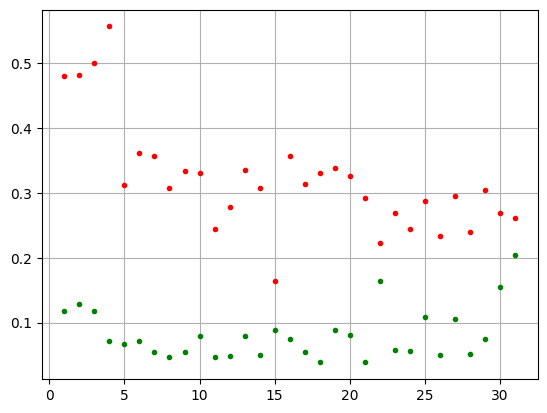

In [18]:
N_file = 7

path_img = os.path.join(lib.PATH_IMG,files[N_file])
data = lib.get_row_image(path_img)


img_doc = data["img"]
npy_mtrx_doc = data["npy"]
rows = data["image_rows"]

mean_row = []
std_row = []
for i in range(len(rows)):
    rez = char_sum_row(rows[i])
    mean_row.append(rez[0])
    std_row.append(rez[1])

x = np.linspace(1, len(mean_row), len(mean_row))
plt.plot(x, mean_row, "r.", x, std_row, 'g.')
plt.grid()

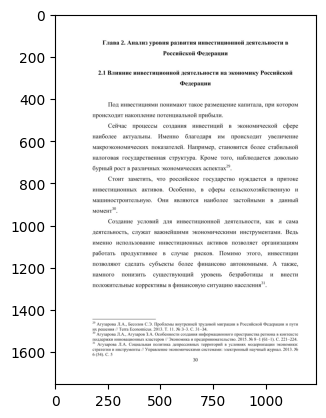

In [19]:
plt.imshow(img_doc)